In [1]:
import glob
import numpy as np
import h5py
from matplotlib.colors import LogNorm
import time
import csv 
from matplotlib.colors import SymLogNorm
from astropy.visualization import ZScaleInterval, ImageNormalize
import os
from astropy.io import fits
import ipywidgets as widgets
from IPython.display import display, clear_output
import random

In [2]:
h5files = sorted(glob.glob('/css/romanst/archive/WFI_TVAC2/HOT_QUAL/OTP00644_Darks_TV2a_R7_MCEB/*/L1A/*.h5') + glob.glob('/css/romanst/archive/WFI_TVAC2/HOT_QUAL/OTP00639_TotalNoise_TV2a_R2_MCEB/*/L1A/*.h5') + glob.glob('/css/romanst/archive/WFI_TVAC2/NOM_OPS/OTP00644_DarksStability_TV2a_R1_MCEB/*/L1A/*.h5') + glob.glob('/css/romanst/archive/WFI_TVAC2/NOM_OPS/OTP00639_TotalNoiseNoEWA_TV2a_R1_MCEB/*/L1A/*.h5') + glob.glob('/css/romanst/archive/WFI_TVAC2/COLD_QUAL/OTP00644_Darks_TV2a_R1_MCEB/*/L1A/*.h5') + glob.glob('/css/romanst/archive/WFI_TVAC2/COLD_QUAL/OTP00639_TotalNoiseCMUOnNoEWA_TV2a_R1_MCEB/*/L1A/*.h5') + glob.glob('/css/romanst/archive/WFI_TVAC2/COLD_QUAL/OTP00639_TotalNoise_TV2a_R1_MCEB/*/L1A/*.h5'))
print(len(h5files))
numbers = np.linspace(1, len(h5files), len(h5files)) - 1
print(h5files[0])

5760
/css/romanst/archive/WFI_TVAC2/COLD_QUAL/OTP00639_TotalNoiseCMUOnNoEWA_TV2a_R1_MCEB/20240416T144200Z-A2_exp1-L1a/L1A/wfi_1a_20663_20240411000359_05.h5


In [3]:
def extract_all_datasets(g,prefix = '', results=None):
    if results is None:
        results = {}
    for key in g:
        try:
            item = g[key]
        except Exception as e:
            print(f"Error opening key {key}: {e}")
            continue
        path = f"{prefix}/{key}"
        if isinstance(item,h5py.Dataset):
            if item.shape == ():                # scalar dataset
                data = item[()]
                print(f"scalar dataset at {path}, value {data}")
            else:
                data = item[:]
                print(f"Dataset at {path}, shape {data.shape}")
            results[path] = data
        elif isinstance(item, h5py.Group):
            extract_all_datasets(item,path, results)

    return results


def madstat(a, axis=None, keepdims=False, std=False):
    """
    MADSTAT - Robust statistics using median and median absolute deviation

    Parameters:  a, array_like
                   Calculate the median absolute deviation of these values.
                 axis, tuple
                   Axis or axes along which the median absolute deviation is
                   computed.
                 keepdims, bool (optional)
                   If this is set to True, the axes which are
                   reduced are left in the result as dimensions with
                   size one. With this option, the result will
                   broadcast correctly against the input array.
                 std, bool (optional)
                   If set True, then the MAD is multiplied by 1.4826 to
                   estimate the standard deviation of normal deviates.
    Returns: Median and median absolute deviation. Optionally returns median
             and estimated standard deviation.
    """
    # Compute the median and median absolute deviation
    median = np.median(a, axis=axis, keepdims=keepdims)
    mad = np.median(np.abs(a-median), axis=axis, keepdims=keepdims)

    # Estimate std() if requested
    if std is True:
        mad *= 1.4826

    # Done
    return(median, mad)

def rowcor(D):
    """
        rowcor(D)
        Reference correction using only the top four rows of reference pixels.
        parameters: D, array
                      The input data cube
        Returns:    nothing
                      This overwrites the input data
    """
    # Get cube dimensions
    nz, ny, nx = D.shape
    # Definitions
    nout = 32       # The WFI uses 32 outputs for full frame readout
    w = nx//nout    # Width of each output in pixels
    count = 3        # Clip off the best/worse few samples for robust statistics

    # Compute first and last image columns for each output
    x0 = np.arange(0, nx, w)    # First cols
    x1 = x0 + w-1          # Last cols
    # Apply reference correction working frame-by-frame and output-by-output

    for z in np.arange(nz):
        for op in np.arange(nout):
            refpix = D[z, 4093:4095, x0[op]:x1[op]]           # Get ref. pixels
            refpix = np.sort(refpix.flatten())[count-1:-count+1]    # Trim outliers
            mu = np.mean(refpix)                                 # Robust mean
            D[z, :, x0[op]:x1[op]] -= mu

pay attention: 6


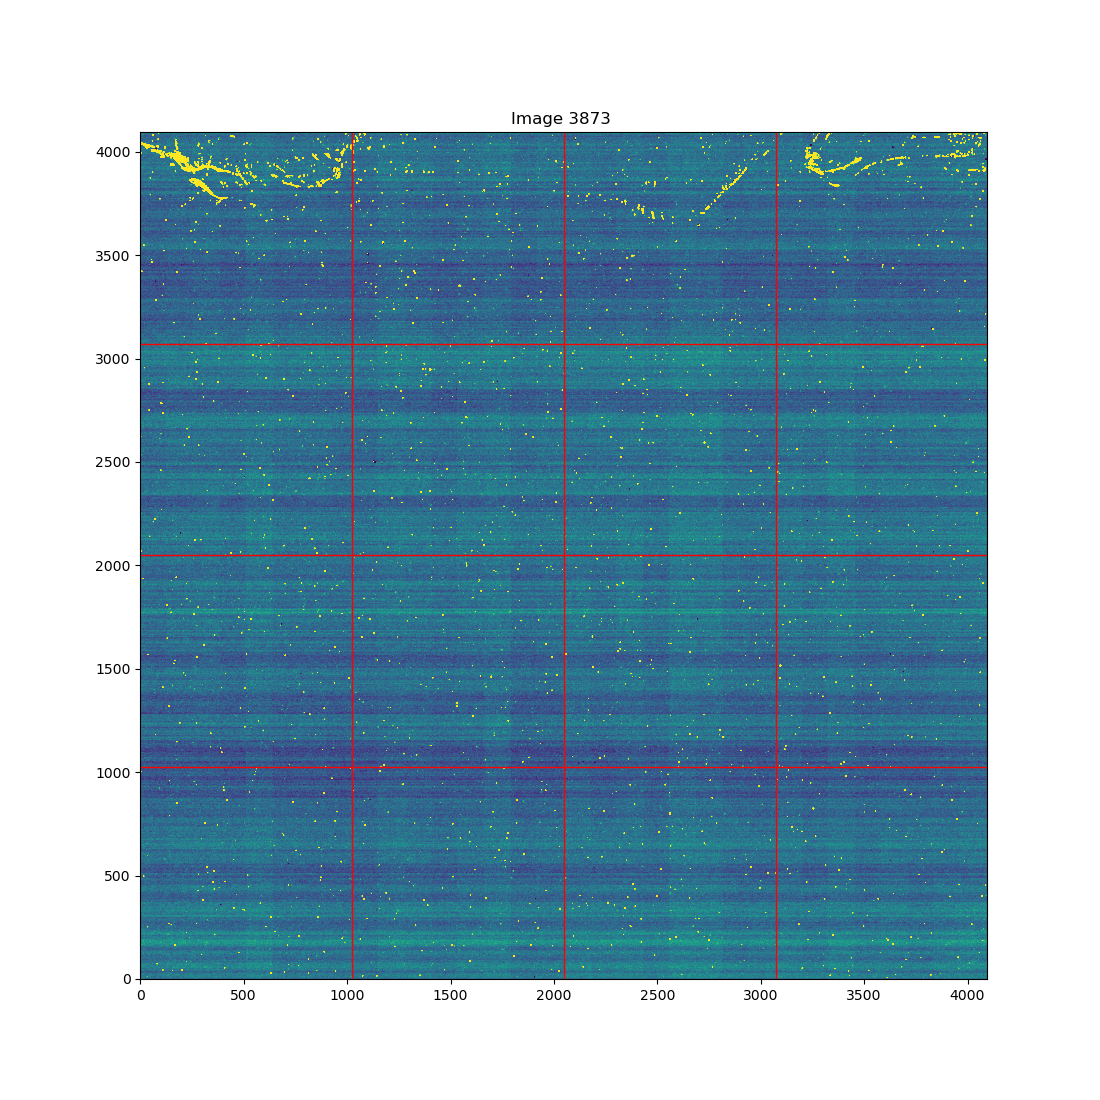

In [6]:
# code num = spreadsheet num - 1
%matplotlib widget

interval = ZScaleInterval()
i = 3873

dark = h5files[0]
# dark = "/css/romanst/archive/WFI_TVAC2/HOT_QUAL/OTP00644_Darks_TV2a_R7_MCEB/20240613T064546Z-WFI_DARKS-DARK-A1_exp3-L1a/L1A/wfi_1a_21814_20240511003725_05.h5"
# or "21947" in dark or "21115" in dark or "21816" in dark or "20663" in dark or "20829" in dark or "21815" in dark:

if "21814" in dark: 
    print("pay attention: 14")

if "21947" in dark: 
    print("pay attention: 11")

if "21115" in dark: 
    print("pay attention: 4")

if "21816" in dark: 
    print("pay attention: 5")

if "20663" in dark: 
    print("pay attention: 6")

if "20829" in dark: 
    print("pay attention: 12")

if "21815" in dark: 
    print("pay attention: 2")

with h5py.File(dark,'r') as f:
    frames = f["Frames"][[1,len(f["Frames"]) - 15], :, :4096].astype(np.float32)
#
rowcor(frames)
cds = frames[1] - frames[0]
vmax = np.percentile(cds, 99)  # or something like np.max(np.abs(cds)) * 0.2
vmin = -vmax
# flip so that it aligns with the reference book
cds = np.fliplr(cds)
#
plt.figure(figsize=(11, 11))
plt.imshow(cds, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
plt.title(f"Image {i} ")
grid_size = 4
rows, cols = grid_size, grid_size

# Calculate step sizes
x_step = cds.shape[1] / cols
y_step = cds.shape[0] / rows

# Draw vertical lines
for x in range(1, cols):
    plt.axvline(x * x_step, color='red', linewidth=1)

# Draw horizontal lines
for y in range(1, rows):
    plt.axhline(y * y_step, color='red', linewidth=1)
plt.show()
